In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

np.random.seed(42)


In [12]:
df = pd.read_csv('Iris Dataset.csv')


print("Dataset Shape:", df.shape)
print("\nFirst few rows of the dataset:")
print(df.head())
print("\nDataset information:")
print(df.info())
print("\nBasic statistics:")
print(df.describe())

Dataset Shape: (150, 6)

First few rows of the dataset:
   Id  SepalLengthCm  SepalWidthCm  PetalLengthCm  PetalWidthCm      Species
0   1            5.1           3.5            1.4           0.2  Iris-setosa
1   2            4.9           3.0            1.4           0.2  Iris-setosa
2   3            4.7           3.2            1.3           0.2  Iris-setosa
3   4            4.6           3.1            1.5           0.2  Iris-setosa
4   5            5.0           3.6            1.4           0.2  Iris-setosa

Dataset information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             150 non-null    int64  
 1   SepalLengthCm  150 non-null    float64
 2   SepalWidthCm   150 non-null    float64
 3   PetalLengthCm  150 non-null    float64
 4   PetalWidthCm   150 non-null    float64
 5   Species        150 non-null    object 
dtyp

<Figure size 1500x1000 with 0 Axes>

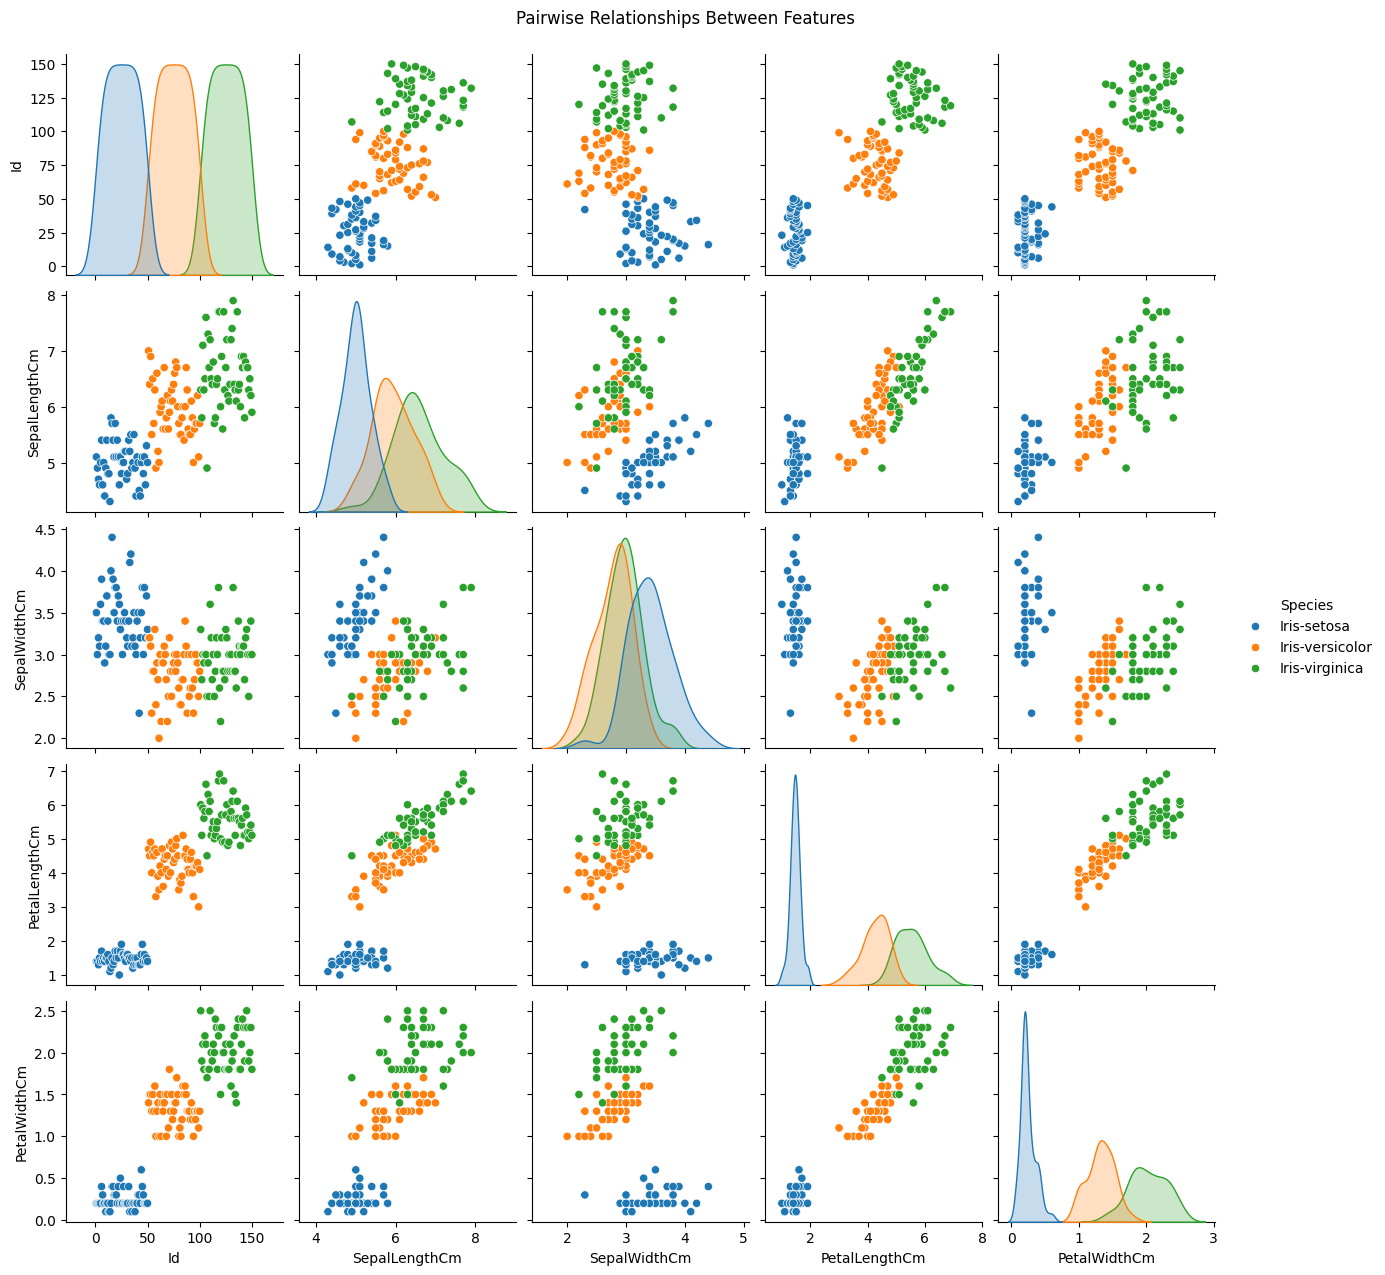

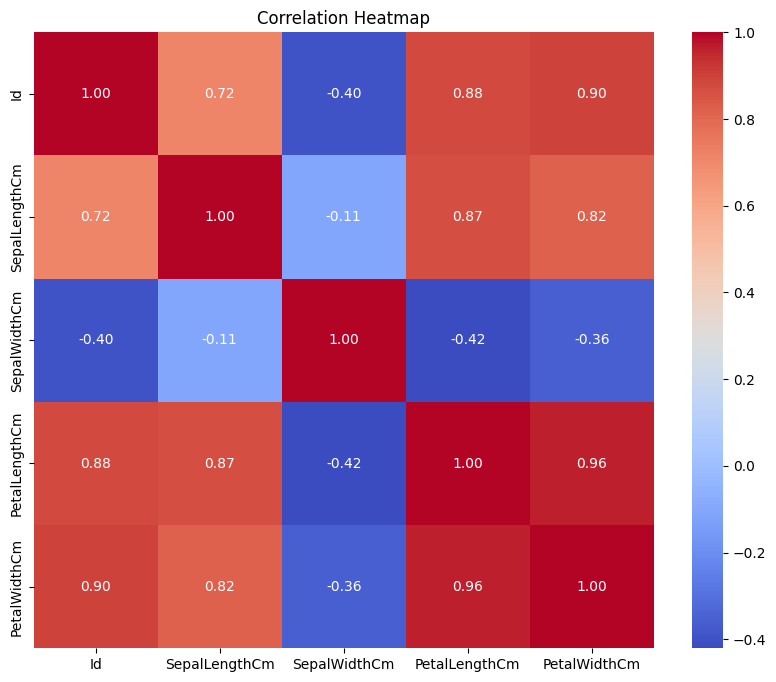

In [ ]:
# Separate features and target
X = df.drop('Species', axis=1)
y = df['Species']

species = y.copy()


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


plt.figure(figsize=(15, 10))


sns.pairplot(df, hue='Species')
plt.suptitle('Pairwise Relationships Between Features', y=1.02)
plt.show()


plt.figure(figsize=(10, 8))


numeric_df = df.select_dtypes(include=[np.number])
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()


In [13]:
class PCA:
    def __init__(self, n_components):
        self.n_components = n_components
        self.components = None
        self.mean = None
        self.eigenvalues = None
        
    def fit(self, X):
        self.mean = np.mean(X, axis=0)
        X_centered = X - self.mean
        cov_matrix = np.cov(X_centered.T)
        eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
        idx = eigenvalues.argsort()[::-1]
        eigenvalues = eigenvalues[idx]
        eigenvectors = eigenvectors[:, idx]
        self.eigenvalues = eigenvalues
        self.components = eigenvectors[:, :self.n_components]
        self.explained_variance_ratio = eigenvalues[:self.n_components] / np.sum(eigenvalues)
        
    def transform(self, X):
        X_centered = X - self.mean
        return np.dot(X_centered, self.components)
    
    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)


Eigenvalues for first three components:
Component 1:
Eigenvalue: 3.7603
Explained Variance Ratio: 0.7471

Component 2:
Eigenvalue: 0.9279
Explained Variance Ratio: 0.1844

Component 3:
Eigenvalue: 0.2357
Explained Variance Ratio: 0.0468



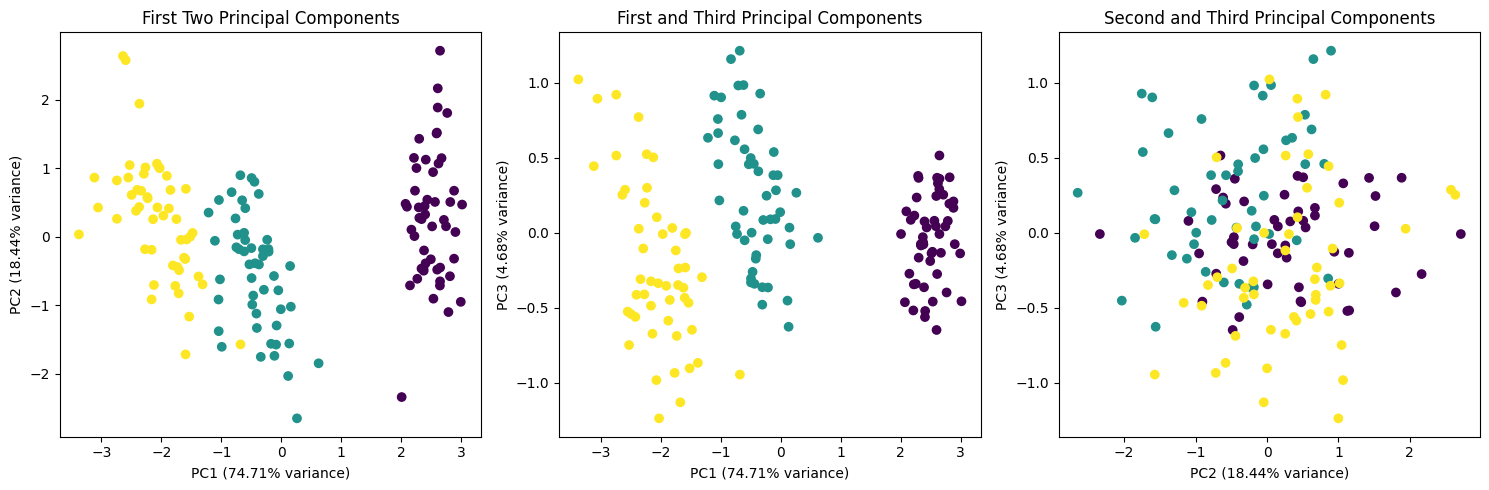

In [7]:
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)

print("Eigenvalues for first three components:")
for i, (eigenvalue, var_ratio) in enumerate(zip(pca.eigenvalues[:3], pca.explained_variance_ratio[:3])):
    print(f"Component {i+1}:")
    print(f"Eigenvalue: {eigenvalue:.4f}")
    print(f"Explained Variance Ratio: {var_ratio:.4f}")
    print()

fig = plt.figure(figsize=(15, 5))

ax1 = fig.add_subplot(131)
scatter = ax1.scatter(X_pca[:, 0], X_pca[:, 1], c=species.astype('category').cat.codes, cmap='viridis')
ax1.set_xlabel(f'PC1 ({pca.explained_variance_ratio[0]:.2%} variance)')
ax1.set_ylabel(f'PC2 ({pca.explained_variance_ratio[1]:.2%} variance)')
ax1.set_title('First Two Principal Components')

ax2 = fig.add_subplot(132)
scatter = ax2.scatter(X_pca[:, 0], X_pca[:, 2], c=species.astype('category').cat.codes, cmap='viridis')
ax2.set_xlabel(f'PC1 ({pca.explained_variance_ratio[0]:.2%} variance)')
ax2.set_ylabel(f'PC3 ({pca.explained_variance_ratio[2]:.2%} variance)')
ax2.set_title('First and Third Principal Components')

ax3 = fig.add_subplot(133)
scatter = ax3.scatter(X_pca[:, 1], X_pca[:, 2], c=species.astype('category').cat.codes, cmap='viridis')
ax3.set_xlabel(f'PC2 ({pca.explained_variance_ratio[1]:.2%} variance)')
ax3.set_ylabel(f'PC3 ({pca.explained_variance_ratio[2]:.2%} variance)')
ax3.set_title('Second and Third Principal Components')

plt.tight_layout()
plt.show()

In [8]:
class KMeans:
    def __init__(self, n_clusters=3, max_iters=100):
        self.n_clusters = n_clusters
        self.max_iters = max_iters
        self.centroids = None
        self.labels = None
        
    def initialize_centroids(self, X):
        n_samples = X.shape[0]
        random_indices = np.random.choice(n_samples, self.n_clusters, replace=False)
        return X[random_indices]
    
    def compute_distance(self, X, centroids):
        distances = np.zeros((X.shape[0], self.n_clusters))
        for k in range(self.n_clusters):
            distances[:, k] = np.sum((X - centroids[k]) ** 2, axis=1)
        return distances
    
    def compute_centroids(self, X, labels):
        centroids = np.zeros((self.n_clusters, X.shape[1]))
        for k in range(self.n_clusters):
            if np.sum(labels == k) > 0:
                centroids[k] = np.mean(X[labels == k], axis=0)
        return centroids
    
    def fit(self, X):
        self.centroids = self.initialize_centroids(X)
        
        for _ in range(self.max_iters):
            distances = self.compute_distance(X, self.centroids)
            self.labels = np.argmin(distances, axis=1)
            
            new_centroids = self.compute_centroids(X, self.labels)
            
            if np.all(self.centroids == new_centroids):
                break
                
            self.centroids = new_centroids
    
    def predict(self, X):
        distances = self.compute_distance(X, self.centroids)
        return np.argmin(distances, axis=1)


Silhouette Score: 0.4555


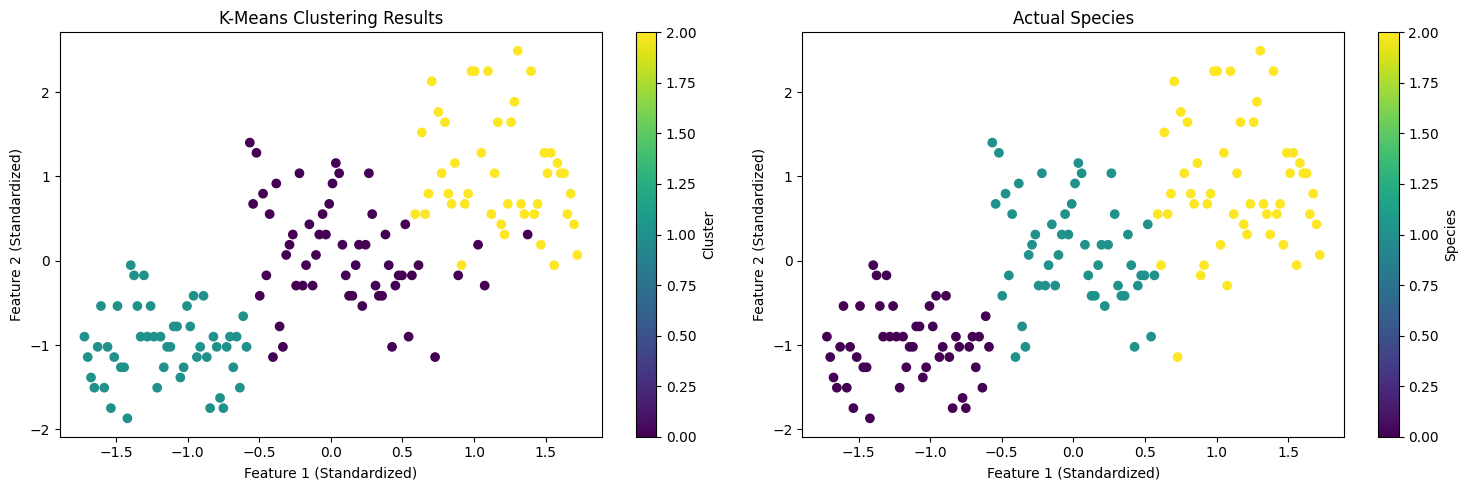

In [9]:
kmeans = KMeans(n_clusters=3, max_iters=100)
kmeans.fit(X_scaled)
cluster_labels = kmeans.labels

silhouette_avg = silhouette_score(X_scaled, cluster_labels)
print(f"Silhouette Score: {silhouette_avg:.4f}")

plt.figure(figsize=(15, 5))

plt.subplot(121)
scatter = plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=cluster_labels, cmap='viridis')
plt.xlabel('Feature 1 (Standardized)')
plt.ylabel('Feature 2 (Standardized)')
plt.title('K-Means Clustering Results')
plt.colorbar(scatter, label='Cluster')

plt.subplot(122)
scatter = plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=species.astype('category').cat.codes, cmap='viridis')
plt.xlabel('Feature 1 (Standardized)')
plt.ylabel('Feature 2 (Standardized)')
plt.title('Actual Species')
plt.colorbar(scatter, label='Species')

plt.tight_layout()
plt.show()


In [10]:
confusion_matrix = pd.crosstab(
    pd.Series(species, name='Actual'),
    pd.Series(cluster_labels, name='Predicted')
)
print("\nConfusion Matrix (Clustering vs Actual Species):")
print(confusion_matrix)



Confusion Matrix (Clustering vs Actual Species):
Predicted         0   1   2
Actual                     
Iris-setosa       0  50   0
Iris-versicolor  50   0   0
Iris-virginica    6   0  44


In [11]:
print("\nSummary of Results:")
print("=" * 50)
print("\nPCA Results:")
print(f"Total variance explained by first 3 components: {sum(pca.explained_variance_ratio[:3]):.4f}")
print("\nK-Means Results:")
print(f"Number of clusters: {kmeans.n_clusters}")
print(f"Silhouette score: {silhouette_avg:.4f}")
print("\nFeature Importance (based on PCA):")
for i, (feature, importance) in enumerate(zip(X.columns, np.abs(pca.components[:, 0]))):
    print(f"{feature}: {importance:.4f}")


Summary of Results:

PCA Results:
Total variance explained by first 3 components: 0.9782

K-Means Results:
Number of clusters: 3
Silhouette score: 0.4555

Feature Importance (based on PCA):
Id: 0.4814
SepalLengthCm: 0.4484
SepalWidthCm: 0.2320
PetalLengthCm: 0.5108
PetalWidthCm: 0.5025
